# 3D Pose Estimation

[*Applied Machine Learning for Health and Fitness*](https://www.apress.com/9781484257715) by Kevin Ashley (Apress, 2020).

[*Video Course*](http://ai-learning.vhx.tv) Need a deep dive? Watch my [*video course*](http://ai-learning.vhx.tv) that complements this book with additional examples and video-walkthroughs. 

[*Web Site*](http://activefitness.ai) for research and supplemental materials.


> Who would believe that so small a space could contain the image of all the universe? O mighty process!
>
> Leonardo da Vinci, Camera Obscura

![](images/ch8/image1.png)

Overview
==============

In the previous chapter you focused on estimating keypoints of the human body pose, mostly based on a flat image. In other words, our goal was reconstructing joints of the human body, without paying attention to analyzing how these joints are positioned in space. The task of estimating position of objects and human body in 3D space is more challenging. Imagine, that you are dealing with a simple RGB camera: the camera works by projecting light it captures in the scene of the real three dimensional world into a sensor. For sport scientists, a video camera is the most obvious source of information, but it's not necessarily the most accurate.

![](images/ch8/image2.PNG)

First, given camera line of sight, some parts of the scene may be hidden from the observer. Also, the camera is limited to a certain rate of frames per second it can capture, while devices such as sensors significantly exceed that rate. Having extra sensors, such as depth (for example LIDAR), infrared, as well as motion sensors, such as IMUs is often a luxury in the field. Getting these sensors installed in a live sports action environment, or on the athlete's body is often impractical, so machine learning often relies on using transfer learning or ground truth data for training. A data scientist can train a model using a ground truth dataset, such as Human3.6m, or data collected from sensors, then let the model infer position from the video.

Despite the massive use of video, hybrid methods combining both sensor and video data are still widely used where conditions permit. A notable example of such approach is used by International Federation of Gymnastics and Fujitsu in Gymnastics Judging AI, which uses a combination of a LIDAR and a camera to provide a near-real-time 3D body pose reconstruction. Methods of pose reconstruction in 3D vary, depending on the inputs. In this chapter we'll investigate methods of reconstructing 3D based on various sources of information: single cameras, multi-view cameras and triangulation and sensors to estimate pose more accurately in 3D space.

In this chapter, we'll start with fundamental principles of camera optics that will help us with 2D-3D reconstruction, to more advanced questions of how our eyes can reconstruct depth in the scene and then using machine learning.

Cameras and 3D world
====================

> "The creation of a single world comes from a huge number of fragments and chaos."
>
> ― Hayao Miyazaki

A pinhole camera, as a device that maps from 3D world into a 2D image plane, has been known for thousands of years, and is mentioned by many ancient writings, including Aristotle, Chinese and Indian. A mathematical model of an ideal pinhole camera, that is the camera without lenses and aperture of a single point, is often used in modeling optics. Mathematically, a pinhole camera matrix *C* makes the mapping by projecting world space points *X* into the image plane *Y*:

![](images/ch8/image3.PNG)

$$Y\  = \ CX$$

In figure 8-3, you can see two similar triangles, with hypotenuses representing projection lines from the hand of the tennis player in the world space to the similar point on the projected image inside the camera on the sensor. Since both triangles are similar:

$- \frac{Y}{f} = \frac{X}{Z}\ \ Y = \  - f\ (\frac{X}{Z})$

This transformation can be written in terms of *projective coordinates* from the world space to image plane. In 3D space, we can write down such a transformation in a matrix form (note, that the below formula applies to an ideal pinhole camera, without a lens):

$$\begin{bmatrix}
y_{1} \\
y_{2} \\
1 \\
\end{bmatrix} = \begin{bmatrix}
f_{x} & 0 & 0 & 0 \\
0 & f_{y} & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}\begin{bmatrix}
x_{1} \\
x_{2} \\
x_{3} \\
1 \\
\end{bmatrix}$$

![](images/ch8/image4.PNG)

Unlike pinhole cameras, actual cameras typically include a lens, and a lens may introduce some distortion. Most cameras distort images, you know that very well, when you take a picture for your Facebook account, and you end up with something that looks less than ideal because your face may look stretched on the sides. Or, if you take a picture of a document, and it looks unreadable: apps like Microsoft OfficeLens can undistort documents, and OpenCV includes undistort method. How's that done? Optical distortion occurs because the camera takes the light coming from a 3D scene of the world and forms a 2D image on the sensor, after that light comes through the lens. On some images, straight lines appear curved, and some objects may appear tilted, closer or farther away. It may not be a big deal for your Facebook or Instagram account, but it's a bigger problem for self-driving cars that need to estimate the curvature of the road. Tangential distortion occurs when the lens is angled relative to the sensor. Radial distortion occurs because the light bends more towards the edges of the lens than in the center.

Camera matrix
=============

To solve the distortion problem and find a camera-specific calibration matrix and distortion coefficients, we can use OpenCV. Calibration matrix can be later saved to a file for later re-use as a Numpy array. To calibrate, OpenCV offers calibrateCamera method that takes points from 3D object space and points from 2D image space and outputs a camera matrix that we can later re-use for calibration.

Project: CAMERA MATRIX AND 3D RECONSTRUCTION

Typically, to calibrate the camera a grid like a chessboard is used. You can take multiple pictures of a chessboard with your camera at different angles, or use a set of images I took in data/camera/chessboard3 folder (usually 10-20 pictures at different angles is sufficient). I included a helper method in utils.pose3d that includes methods for camera calibration, based on OpenCV:

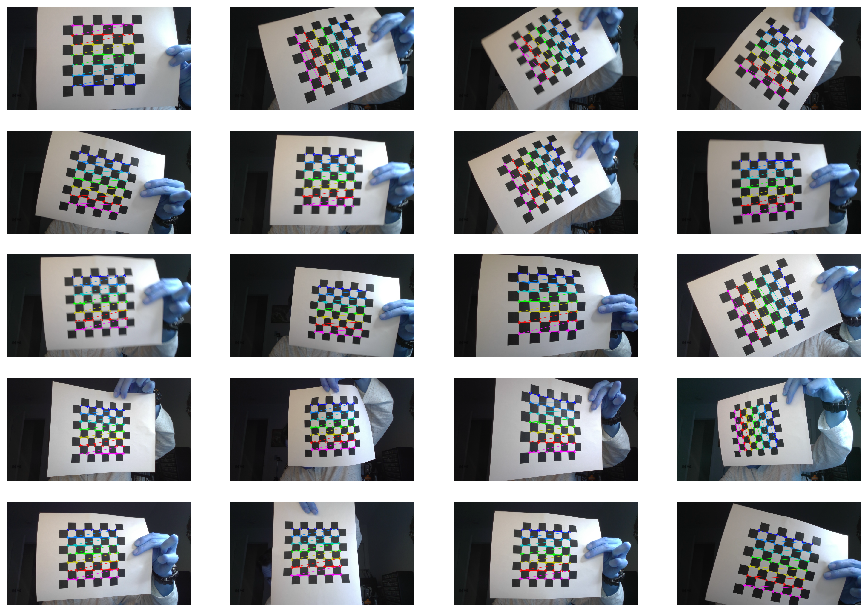

In [2]:
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from utils.pose3d import pose3d
%matplotlib inline

images = glob.glob('data/camera/chessboard3/*.jpg')
points_3d, points_2d = pose3d.find_corner_points(images)
img = cv2.imread(images[0])
# calibrate
_, M, D, R, T = cv2.calibrateCamera(points_3d, points_2d, (img.shape[1], img.shape[0]), None, None)
dist_pickle = {}
dist_pickle["mtx"] = M
dist_pickle["dist"] = D
# save calibration
pickle.dump(dist_pickle, open( "data/camera/calibration.pickle", "wb" ))                 

                 
In this example, I used calibrateCamera method from OpenCV, which returns 3x3 camera matrix M, a vector of distortion coefficients D, vector of rotation R and the vector of translation T. We can save camera matrix and distortion vector in the pickle file and reuse them later, because they are specific to the camera. Next, we can plot axis of a reconstructed 3D space based on the camera matrix:

    

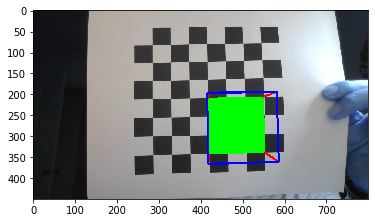

In [3]:
img = pose3d.find_3d_cube(images[0],M,D)
plt.imshow(img)
plt.show()                          
                            

In this example you walked through camera calibration process, and reconstructing a 3D view based on a special pattern, like a checkerboard, after you calculated camera matrix and distortion.

![](images/ch8/image6.PNG)

Using a single camera
===========================

A single view camera can be used to reconstruct a 3D human body pose using a convolution network. Most models use a set of 2D keypoints detected using models we discussed in the previous chapter, and then reconstructing a regression to the 3D space.

For a sport data scientist this ability to use a very basic video data to analyze human body in 3D space is very valuable. While keypoints can be used for pose representation, a more accurate estimation of fully blended 3D body shapes can also be done with models like SMPL (Skinned Multi-Person Linear Model), as illustrated on the following figure. Models for human body reconstruction to full 3D including joints or shapes have achieved an impressive performance recently, with the mention of a notable SMPLify method estimating 3D body pose and shape from a single image!

![](images/ch8/image7.PNG)

In the next section we'll go over another method that applies 3D triangulation from multiple views, similarly to what our eyes are using to reconstruct depth in the scene.

Multi-view depth reconstruction
===============================

![](images/ch8/image8.PNG)

There's a reason why humans and many other biological forms on our planet have a pair of eyes. In modern science many insights come from our understanding of how we perceive the world, and multi-view vision is one of the most interesting insights about vision data. A single image carries a lot of information, but it's missing a key data point that our brain needs to accurately reconstruct 3D images: depth! Without depth any image is ambiguous, that is, it makes it hard for our brain to differentiate distance to objects. Knowing depth makes it easier to estimate distance in the visual scene, and that is a critical component to our understanding of the 3D environment.

In fact, what our brain is doing with two eyes is called triangulation. It's very easy to explain: with one eye, using pinhole camera model we only have one image plane, every point from the 3D ![][8]world along the straight line projects to a single point on the image plane! With an additional eye, looking at the line from a slightly different angle, we can see multiple points, so our brain can triangulate the 3D points! In Figure 8-7 "Multi-view triangulation", if you only look at points P1 and P2 with one eye O, your eye will not see the difference between these points, because they project on the image plane of eye O to a point X. Line XE corresponding to the point X is called *epiline*. With the second line O' we can create a plane XOO' called *epipolar plane* and project points on OX to the second image plane. How do we find the matching point on the second image? This task is simplified because of what's called an *epipolar constraint*: to find a matching point we don't need to search all points on the second image plane, we can only search points along the epiline. But because the second eye O' is at an angle, instead of one point we can see multiple points (in our case X2 and X1) on the second *epiline*! This method allows optically reconstructing one of the most important aspects of 3D imaging, depth.

In the next section I'll go over a method of reconstructing a 3D object with sensors, a method often used in motion caption processing. The multi-view 3D triangulation we discussed earlier is used in practical frameworks, such as for example, DeepLabCut, and require a setup with multiple cameras.

3D reconstruction with sensors
==============================

> "I thought 2-D and 3-D could coexist happily."
>
> ― Hayao Miyazaki

In addition to vision, sensors such as IMUs (inertial movement units) can be used to provide data for 3D pose reconstruction. Well calibrated sensor units, such as Xsens can provide a high quality motion capture that can be used as a ground truth data for training models, or to analyze and visualize human body pose in 3D directly, often with much higher precision than vision data. We already discussed why using inertial movement sensors may be beneficial for 3D data capture, but it's worth reiterating the main reasons in the context of 3D reconstruction:

-   Sensor data, such as IMU, unlike vision-only information often provides full 3D transformation, including acceleration, rotation and displacement.

-   Sensor data in the IMU typically comes at a very high rate (often 100 or 200 Hz), while visual data is typically capped at 30-60 fps.

-   Range measuring sensors, such as LIDARs can also be used to provide depth information

Motion capture
==============

> If you can dream it, you can do it.
>
> Walt Disney

![](images/ch8/image9.PNG)

Motion capture (mocap) has emerged from studio animation and simulation domain, to become a valuable tool for collecting high quality datasets for machine learning. Traditionally, mocap is used to create high quality studio animations and animated sequences for interactive applications, movies, games and simulations, and in sports for high precision analysis of athletic movements. Many sports organizations I worked with, including the US Ski Team, NBA, NFL, WTA and Professional Ski and Snowboard Instructors of America apply motion capture and video analytics. I hope this book makes it easier for them and many sport professionals involved in human performance research to use methods described here.

3D Datasets
===========

Before starting with the models, let's spend some time discussing datasets available for 3D pose estimation. These datasets may use different motion capture methods, size and categories of actions. Checking assumptions made during data collection of these datasets is important if you are planning to use models trained with this data and train your own models. Some datasets include ground truth data (that is data coming from motion capture systems and sensors). Some of the most widely used datasets used to train 3D models are:

-   Human3.6m contains 3.6 million 3D human images taken from several cameras. The dataset is organized into several categories corresponding to various actions.

-   HumanEva dataset contains video sequences synchronized with body points taken from a motion capture system

There're other datasets available, including those based on synthetic data, such as games: e.g. JTA Dataset (Grand Theft Auto), SURREAL (Synthetic hUmans foR REAL tasks). DensePose-COCO dataset is a part of Facebook DensePose project that has 50K humans annotated with 5 million labels corresponding to body parts. Leeds Sports Pose dataset contains about 2K images with 14 joint positions. For training models including shapes, some recent datasets use SMPL, like AMASS (Archive of Motion Capture as Surface Shapes).

![](images/ch8/image10.PNG)

3D Machine Learning Methods
==================================

A human 3D body pose reconstruction is more challenging than a two-dimensional approach we've done in the previous chapter. The first pages of this chapter gave you some fundamentals of 3D reconstruction, from the simplest pinhole camera, calibrating and using libraries such as OpenCV to reconstruct 3D space, to basics of depth triangulation with multi-view cameras. As sport data scientists, our primary interest is of course in analyzing and reconstructing a human body. This is a much more complicated task, and it turns out that machine learning can help.

![](images/ch8/image11.PNG)

Some models use two-dimensional detections as input for the 3D pose estimations. What came as a rather pleasant surprise for data scientists in the recent years of research, is the low error rates of lifting ground truth body joint locations to predict 3D positions! It turns out, that once two-dimensional joint locations have been detected (like you did in the previous chapters projects!), it's possible to design a network that uses joint angles and bone lengths for human body inference in 3D space. This approach typically involves a two-step process, where each step is separate: in the first step the two-dimensional keypoints are detected, in the second step the model performs the inference in 3D space. In more recent research, it was shown that a 2D-3D transfer learning can be more efficient, when the layers detecting two-dimensional keypoints directly connect with the depth-regression layer in the same network.

For many sports, it is important to detect groups of people. Fortunately, most models for 2D and 3D body pose estimations apply for detection in the group. One of the most important aspects of group detection for sports scenarios is performance.

Sparse and Dense Reconstruction
===============================

![](images/ch8/image12.PNG)

When using a model to represent human body, you have a choice of models based on relatively sparse joints representation (usually 17 or 25 joints) and those using mesh or surface. In the previous chapter we used a keypoint detection method, applying a built-in Pytorch RCNN ResNet FPN model trained on COCO dataset classes to detect keypoints of a surfer:

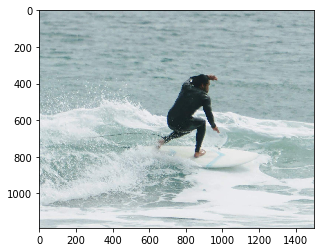

In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
%matplotlib inline

img = Image.open('./media/surfer.jpg')
plt.imshow(img); plt.show()

def normalize(img):
    normalize_t = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)

img_tensor = normalize(img)

kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()
detection = kprcnn(img_tensor)[0]

In [2]:
import torch
import utils.pose3dn.lib
from utils.pose3dn.lib.utils.eval import get_preds, get_preds_3d
from utils.pose3dn.joints import get_keypoint_detections, to_json

keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [925, 418, 1], "left_eye": [924, 406, 1], "right_eye": [919, 408, 1], "left_ear": [887, 408, 1], "right_ear": [893, 409, 1], "left_shoulder": [801, 417, 1], "right_shoulder": [907, 476, 1], "left_elbow": [838, 375, 1], "right_elbow": [925, 566, 1], "left_wrist": [910, 366, 1], "right_wrist": [951, 632, 1], "left_hip": [713, 590, 1], "right_hip": [774, 626, 1], "left_knee": [774, 663, 1], "right_knee": [887, 614, 1], "left_ankle": [686, 709, 1], "right_ankle": [863, 766, 1]}]'

This approach of detecting keypoints in 2D is used as a base for 3D pose regression in many machine learning models.

Another type of models also often called dense models, such as Facebook's DensePose takes another approach and uses the shape of the human body. Many dense models are based on Skinned Multi-Person Linear Model (SMPL).

The following example is using DensePose to infer an athlete dense pose using a prebuilt model available with the framework. The inference is done with infer\_simple.py tool that comes as part of the toolkit. This call takes an image of an athlete and generates two images that contain I,U,V channels with resulting segments detected by the model, which makes it easy to overlay the inferred shape against the actual source image:

![](images/ch8/image14.PNG)

In [ ]:
!python2 tools/infer_simple.py --cfg configs/DensePose_ResNet101_FPN_s1x-e2e.yaml --output-dir DensePoseData/infer_out/ --image-ext jpg --wts https://dl.fbaipublicfiles.com/densepose/DensePose_ResNet101_FPN_s1x-e2e.pkl DensePoseData/demo_data/surf4.jpg

If you want to visualize these images, this snippet helps combining resulting channels:

In [ ]:
fig = plt.figure(figsize=[30,30])
plt.imshow(   np.hstack((IUV[:,:,0]/24. ,IUV[:,:,1]/256. ,IUV[:,:,2]/256.))  )
plt.axis('off') ; 
plt.show()

This resulting segment information can also be used to draw a contour of the body:

In [ ]:
fig = plt.figure(figsize=\[30,30\])
plt.imshow( im\[:,:,::-1\] )
plt.contour( INDS, linewidths = 4 )
plt.show()

As part of Tensorflow Graphics, tensorflow recently introduced a new method that uses mesh semantic segmentation of a 3D mesh. In describing the method used for this segmentation, Tensorflow refers to a method called Feature Steered Graph Convolutions for 3D Shape Analysis. Tensorflow also conveniently provides a tool inside TensorBoard that visualizes the 3D mesh.

Summary
=======

Human pose estimation methods using machine learning have significantly advanced in the last few years, triggering a revolution in many industries, including gaming, fashion, sports and robotics. We now have better ways to collect ground truth data with sensors and synchronized video, as part of the motion capture (mocap). And while motion capture for sports has elements of art and science at the same time and understanding mocap tools and limitations of each method of motion capture still comes with practice and expertise, a data scientist today has datasets available for research. In this chapter we discussed basic principles of camera optics and fundamentals of 3D reconstruction with a monocular and multi-view camera. We also discussed datasets and some of the most advanced methods for 3D pose reconstruction available today and discussed sparse and dense reconstruction. I hope from reading this chapter you had a good overview of some of the basics, as well as more advanced machine learning techniques.

## Reference

[*Video Course*](http://ai-learning.vhx.tv) Need a deep dive? Watch my [*video course*](http://ai-learning.vhx.tv) that complements this book with additional examples and video-walkthroughs. 

[*Web Site*](http://activefitness.ai) for research and supplemental materials.